In [1]:
!pip install -r requirements.txt

In [2]:
from googletrans import Translator
from diffusers import StableDiffusionPipeline
import torch
import clip
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from IPython.display import display, clear_output

In [3]:
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 15
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    image_gen_size = (384, 384)
    image_gen_guidance_scale = 7

In [4]:
from diffusers import StableDiffusionPipeline
import torch

# Load the Stable Diffusion model with proper arguments
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, 
    torch_dtype=torch.float32,  # Keep this for CPU, or use torch.float16 if using GPU
)

# Move model to the correct device (CPU or GPU)
image_gen_model = image_gen_model.to(CFG.device)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/codespace/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
def generate_image(prompt, model):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]

    image = image.resize(CFG.image_gen_size)
    return image

In [6]:
def get_translation(text, dest_lang):
    translator = Translator()
    translated_text = translator.translate(text, dest=dest_lang)
    return translated_text.text

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [8]:
def calculate_clip_score(prompt, image):
    image = preprocess(image).unsqueeze(0).to(device)
    text = clip.tokenize([prompt]).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (image_features @ text_features.T).item()
    return similarity

In [9]:
def calculate_ssim(image1, image2):
    image1 = np.array(image1.convert('L'))
    image2 = np.array(image2.convert('L'))
    score, _ = ssim(image1, image2, full=True)
    return score

In [10]:
def generate_and_evaluate(prompt):
    translated_prompt = get_translation(prompt, "en")
    generated_image = generate_image(translated_prompt, image_gen_model)
    display(generated_image)

    clip_score = calculate_clip_score(translated_prompt, generated_image)
    print(f"CLIP Score: {clip_score}")
    reference_image = Image.new('RGB', CFG.image_gen_size, color='white')

    ssim_score = calculate_ssim(generated_image, reference_image)
    print(f"SSIM: {ssim_score}")

Text(value='', description='Prompt:', placeholder='Type something')

Button(description='Generate Image', icon='check', style=ButtonStyle(), tooltip='Click me')

Button(button_style='danger', description='Clear', icon='times', style=ButtonStyle(), tooltip='Clear all outpu…

  0%|          | 0/15 [00:00<?, ?it/s]

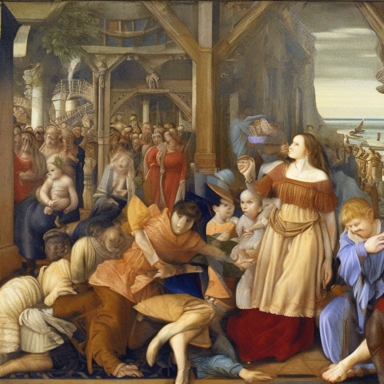

CLIP Score: 0.23325765132904053
SSIM: 0.2123573044528421


In [11]:
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Prompt:',
    disabled=False
)
generate_button = widgets.Button(
    description='Generate Image',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)

clear_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='danger',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Clear all outputs',
    icon='times'
)
def on_generate_button_clicked(b):
    generate_and_evaluate(text_input.value)

def on_clear_button_clicked(b):
    clear_output()
    display(text_input)
    display(generate_button)
    display(clear_button)

generate_button.on_click(on_generate_button_clicked)
clear_button.on_click(on_clear_button_clicked)

display(text_input)
display(generate_button)
display(clear_button)